# CIS 4780 - Assignment 2

Name: Kyle Lukaszek

ID: 1113798

Due: October 27th, 2023

Be sure to read all the cells for a better understanding of the code and the results.

In [ ]:
%pip install pandas numpy matplotlib scikit-learn torchvision torch

## Imports and Initializations

In [9]:
import time
import torch
import torch.nn as nn
import torchvision as tv
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import f1_score

# I have a GPU on my computer, so I want to use it if possible. If no GPU is found, a CPU will be used.
if torch.cuda.is_available():    
    # PyTorch can use CUDA cores to speed up training.
    device = torch.device("cuda")
    print("Using GPU")
else:
    print("Using CPU")

# Classes for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Define Load CIFAR-10 Data Function

The raw flag determines if the function returns the raw data for train and test data, or PyTorch dataloaders for the training and test sets.

In [10]:
def load_CIFAR10(batch_size:int, raw=False):

    # This variable is used to enable pin_memory on the data loaders if a GPU is available.
    gpu_memory = False

    if torch.cuda.is_available():
        gpu_memory = True

    # Define the transformation and normalization to be applied on the images
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

    # Load the training set
    train_set = tv.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    
    # Load the test set
    test_set = tv.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Return the raw datasets if requested
    if raw:
        return train_set, test_set

    # Create a training set dataloader
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=gpu_memory)
    
    # Create a test set dataloader
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=gpu_memory)

    return train_loader, test_loader
    


## Part 1: Feed Forward Neural Network

### Define Feed Forward Neural Network Class

Uses sigmoid activation function for hidden layers, and softmax on the output layer.

- This class takes the following parameters:
    - input_size: Size of image input
    - hidden_size: Number of hidden nodes
    - num_classes: Number of classes in the dataset
    - num_hidden_layers: Number of hidden layers

In [11]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers, num_classes, randomize_weights=False):
        # Initialize the parent class (nn.Module)
        super(FeedForwardNN, self).__init__()

        # Flatten the input layer
        self.flatten = nn.Flatten()
        layers = []

        # Define sigmoid activation function
        self.sigmoid = nn.Sigmoid()

        size = input_size
        # Add the correct number of hidden layers
        for _ in range(num_hidden_layers):
            layer = nn.Linear(size, hidden_size)

            # Initialize weights based on the randomize_weights flag
            if randomize_weights:
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='sigmoid')
            else:
                nn.init.zeros_(layer.weight)

            # Initialize biases to 0
            nn.init.zeros_(layer.bias)

            layer.sigmoid = nn.Sigmoid()
            layers.append(layer)
            size = hidden_size

        # Set hidden layers
        self.hidden_layers = nn.Sequential(*layers)

        # Define the output layer  
        self.fc_out = nn.Linear(hidden_size, num_classes)

        # Initialize weights based on the randomize_weights flag
        if randomize_weights:
            nn.init.kaiming_uniform_(self.fc_out.weight, nonlinearity='sigmoid')
        else:
            nn.init.zeros_(self.fc_out.weight)

        # Initialize biases to 0
        self.fc_out.bias.data.fill_(0)

    def forward(self, x):        
        # Flatten the input
        x = self.flatten(x)

        # Pass through hidden layers
        x = self.hidden_layers(x)

        # Get the output layer
        out = self.fc_out(x)

        # Return softmax of the output layer
        return nn.functional.softmax(out, dim=1)


### Define Test Function

In [12]:
def test_model(test_loader, input_size, model):
    # Set the model to evaluation mode
    model.eval() 

    # Disable gradient calculation
    with torch.no_grad():
        total_correct = 0
        total_samples = 0

        # Iterate over the data in the test data loader
        for images, labels in test_loader:
            # Reshape the images and move them to the device (GPU or CPU)
            images = images.view(-1, input_size).requires_grad_().to(device)

            # Forward pass through the model
            outputs = model(images) 

            # Get the predicted labels
            _, predicted = torch.max(outputs, 1)

            # Update the total number of samples
            total_samples += labels.size(0) 

            # Move the data to the CPU if GPU is being used, and calculate the number of correct predictions
            if torch.cuda.is_available():
                total_correct += (predicted.cpu() == labels.cpu()).sum().item()
            else:
                total_correct += (predicted == labels).sum().item()

        accuracy = 100 * total_correct / total_samples  # Calculate the accuracy
        error_rate = 100 - accuracy  # Calculate the error rate
        return error_rate  # Return the error rate

### Define Train and Test Function

In [13]:
# Function to train and test the model
def train_and_test(input_size, train_loader, test_loader, hidden_size, num_classes, num_hidden_layers, num_epochs, learning_rate, randomize_weights=False):

    # Initialize the model
    model = FeedForwardNN(input_size, hidden_size, num_hidden_layers, num_classes, randomize_weights=randomize_weights)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Lists to store error rates
    train_error_rates = []
    test_error_rates = []

    # Training loop
    for epoch in range(num_epochs):
        total_correct = 0
        total_samples = 0

        # Iterate over the data in the training data loader (M-BGD)
        for i, (images, labels) in enumerate(train_loader):
            # Reshape the images and move them to the device (GPU if available)
            images = images.view(-1, input_size).requires_grad_().to(device)

            # Move the labels to the device (GPU if available)
            labels = labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Perform a forward pass through the model
            outputs = model(images)

            # Calculate the loss using cross-entropy loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()  # Perform backpropagation
            optimizer.step()  # Update the model parameters

            # Get the predicted labels
            _, predicted = torch.max(outputs, 1)

            # Update the total number of samples
            total_samples += labels.size(0)

            # Move the data to the CPU if GPU is being used, and calculate the number of correct predictions
            if torch.cuda.is_available():
                total_correct += (predicted.cpu() == labels.cpu()).sum().item()
            else:
                total_correct += (predicted == labels).sum().item()

        # Calculate training error rate and append to list
        train_accuracy = 100 * total_correct / total_samples
        train_error_rate = 100 - train_accuracy
        train_error_rates.append(train_error_rate)

        # Test the model and append test error rate to list
        test_error_rate = test_model(test_loader, input_size, model)
        test_error_rates.append(test_error_rate)

    return train_error_rates, test_error_rates

### Part 1.1: Randomly Initialized Weights

#### a) Batch Size = 200

Files already downloaded and verified
Files already downloaded and verified
Training Error Rates: [76.958, 70.91, 67.322, 65.634, 64.672, 64.042, 63.504, 63.012, 62.542, 62.218]
Test Error Rates: [72.74, 68.27, 65.97999999999999, 64.66, 63.8, 63.23, 62.85, 62.6, 62.32, 61.97]


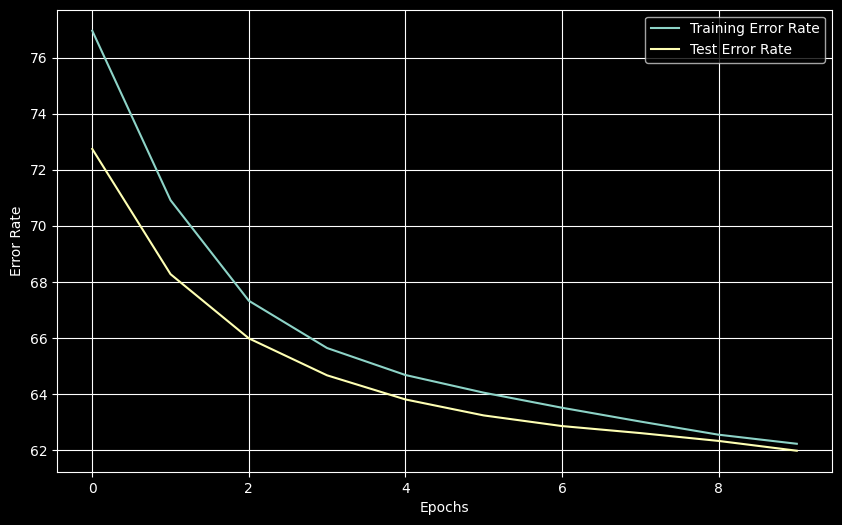

In [14]:
input_size = 3072
batch_size = 200
hidden_size = 300
num_classes = 10
num_hidden_layers = 1
num_epochs = 10
learning_rate = 0.01
randomize_weights = True

# Load the datasets
train_loader, test_loader = load_CIFAR10(batch_size=batch_size)

lambda_values = list(range(0, 251))

# Scale lambda values to [0, 1]
lambda_values = np.array(lambda_values).reshape(-1, 1)
lambda_scaler = MinMaxScaler(feature_range=(0, 1))
lambda_scaler.fit(lambda_values)
lambda_values = lambda_scaler.transform(lambda_values).squeeze()

# Train and test the model
train_error_rates, test_error_rates = train_and_test(input_size, train_loader, test_loader, hidden_size, num_classes, num_hidden_layers, num_epochs, learning_rate, randomize_weights)

print(f'Training Error Rates: {train_error_rates}')
print(f'Test Error Rates: {test_error_rates}')

# Plot the error rates
plt.figure(figsize=(10, 6))
plt.plot(train_error_rates, label='Training Error Rate')
plt.plot(test_error_rates, label='Test Error Rate')
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()

#### Explanation:

This is a simple test of the data using the FFN with randomized weights and a batch size of 200. We will be using a batch size of 200 for the rest of the tests in the assignment so it is nice to see what the default performance of the model looks like with very simple hyperparameters. As we can see, as the number of epochs increases, the training error rate and the testing error rate begin to converge.

#### b) Various Epochs

Files already downloaded and verified
Files already downloaded and verified
Epochs Tested: 10
Epochs Tested: 20
Epochs Tested: 30
Epochs Tested: 40
Epochs Tested: 50
Best Training Error Rate: 56.946 from 50 epochs
Best Test Error Rate: 58.92 from 50 epochs


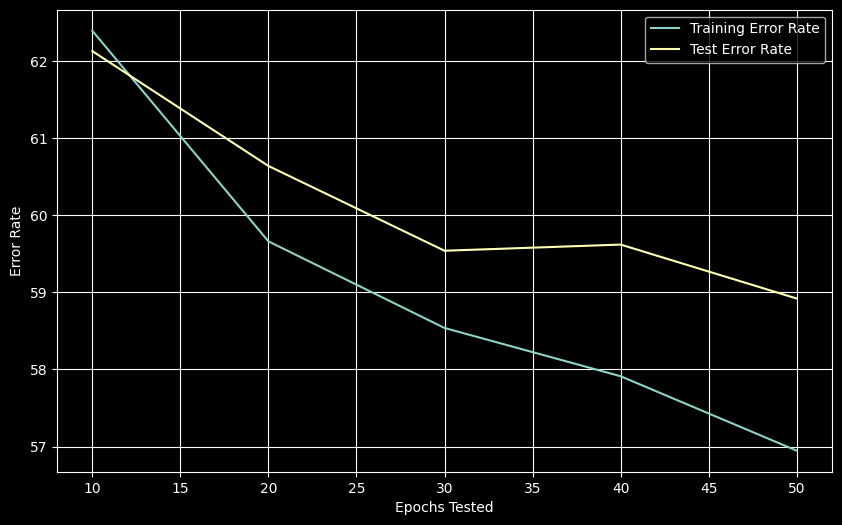

In [8]:
input_size = 3072

# Values are from the updated assignment instructions posted on Courselink 
batch_size = 200
hidden_size = 300
num_classes = 10
num_hidden_layers = 1
learning_rate = 0.01
randomize_weights = True

epochs = [10, 20, 30, 40, 50]

train_error_rates = []
test_error_rates = []

# Load the datasets
train_loader, test_loader = load_CIFAR10(batch_size=batch_size)

# Train and test the model for each number of epochs
for num_epochs in epochs:
    train_results, test_results = train_and_test(input_size, train_loader, test_loader, hidden_size, num_classes, num_hidden_layers, num_epochs, learning_rate, randomize_weights)
    
    # Append the final error rates to their respective lists
    train_error_rates.append(train_results[-1])
    test_error_rates.append(test_results[-1])

    print(f'Epochs Tested: {num_epochs}')

print(f'Best Training Error Rate: {min(train_error_rates)} from {epochs[train_error_rates.index(min(train_error_rates))]} epochs')
print(f'Best Test Error Rate: {min(test_error_rates)} from {epochs[test_error_rates.index(min(test_error_rates))]} epochs')

# Plot the error rates
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_error_rates, label='Training Error Rate')
plt.plot(epochs, test_error_rates, label='Test Error Rate')
plt.xlabel('Epochs Tested')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()

##### Explanation:

- Best Training Error Rate: 56.946% (50 epochs)
- Best Testing Error Rate: 58.92% (50 epochs)

The accuracy of the model increases as the number of epochs increases. This is because the model is being trained for longer, and therefore is able to learn more about the data. The accuracy of the model on the training data is higher than the accuracy on the test data, which is expected. This is because the model is being trained on the training data, and therefore is able to learn more about it. The accuracy of the model on the test data does increase between 30 and 40 epochs, which indicates some form of overfitting, but once we do 50 epochs out test error rate decreases again.

#### c) 1 Hidden Layer, Various Hidden Nodes

Files already downloaded and verified
Files already downloaded and verified
Best Training Error Rate: 56.856 from 300 hidden nodes
Best Test Error Rate: 58.67 from 250 hidden nodes


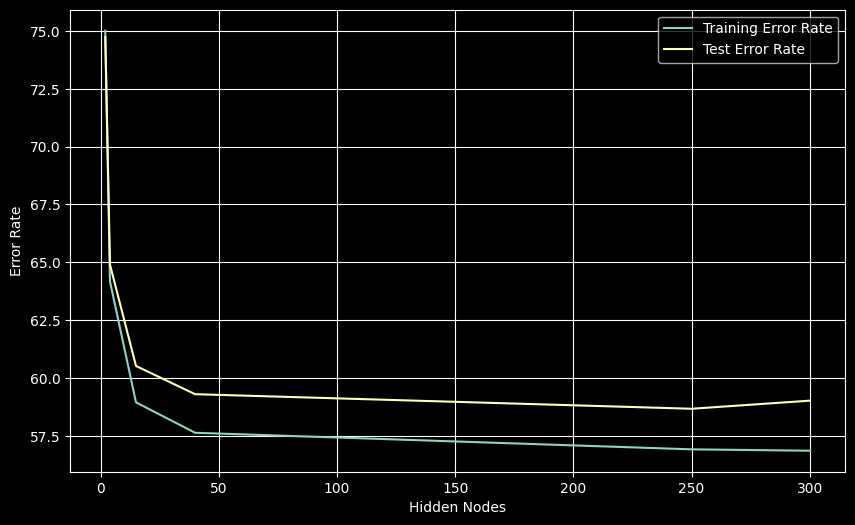

In [9]:
input_size = 3072
batch_size = 200
num_classes = 10
num_hidden_layers = 1
epochs = 50 # Best number of epochs from previous step
learning_rate = 0.01
randomize_weights = True

hidden_sizes = [2, 4, 15, 40, 250, 300]

train_error_rates = []
test_error_rates = []

# Load the datasets
train_loader, test_loader = load_CIFAR10(batch_size=batch_size)

# Train and test the model for each hidden size
for hidden_size in hidden_sizes:
    train_results, test_results = train_and_test(input_size, train_loader, test_loader, hidden_size, num_classes, num_hidden_layers, epochs, learning_rate, randomize_weights)
    
    # Append the final error rates to their respective lists
    train_error_rates.append(train_results[-1])
    test_error_rates.append(test_results[-1])

print(f'Best Training Error Rate: {min(train_error_rates)} from {hidden_sizes[train_error_rates.index(min(train_error_rates))]} hidden nodes')
print(f'Best Test Error Rate: {min(test_error_rates)} from {hidden_sizes[test_error_rates.index(min(test_error_rates))]} hidden nodes')

# Plot the error rates
plt.figure(figsize=(10, 6))
plt.plot(hidden_sizes, train_error_rates, label='Training Error Rate')
plt.plot(hidden_sizes, test_error_rates, label='Test Error Rate')
plt.xlabel('Hidden Nodes')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()

##### Explanation:

- Best Training Error Rate: 56.856% (300 hidden nodes)
- Best Test Error Rate: 58.67% (250 hidden nodes)

The error rate of the model decreases as the number of hidden nodes increases. This makes sense since we are using a complex dataset of images and the more nodes we use, the more the model can learn from the data. The error rate of the model on the training data is lower than the error rate on the test data, which is expected. This is because the model is being trained on the training data, and therefore is able to learn more about it. We also see that the error rate of the model on the test data seems to be overfitting at 250 hidden nodes, since the error rate increases after that.

#### d) Random Weights & Bias = 0 Vs. Weights = 0 & Bias = 0

Files already downloaded and verified
Files already downloaded and verified
Random Weights Training Error Rate: 56.958
Random Weights Test Error Rate: 58.86

Zero Weights Training Error Rate: 90.218
Zero Weights Test Error Rate: 90.0


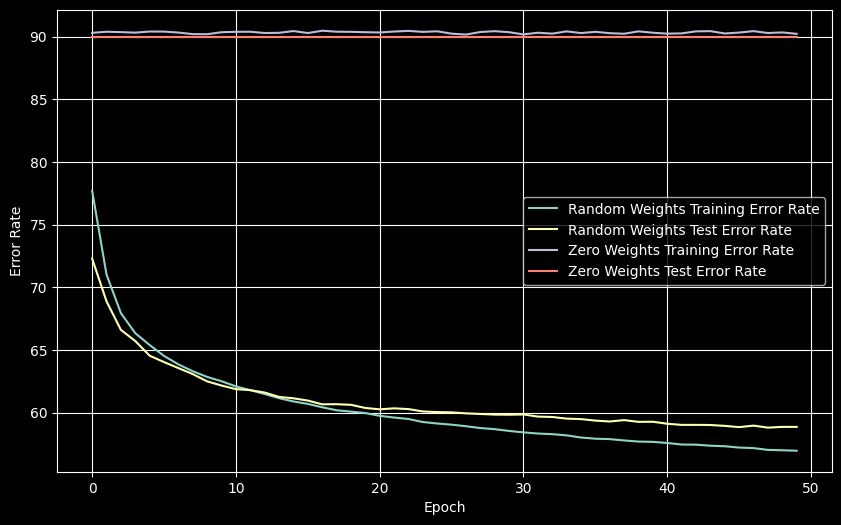

In [10]:
input_size = 3072
batch_size = 200
hidden_size = 250 # Best hidden size from previous step
num_hidden_layers = 1
num_classes = 10
epochs = 50 # Best number of epochs from previous step
learning_rate = 0.01
randomize_weights = True

# Load the datasets
train_loader, test_loader = load_CIFAR10(batch_size=batch_size)

# Train and test the model with randomized weights
random_train_error_rates, random_test_error_rates = train_and_test(input_size, train_loader, test_loader, hidden_size, num_classes, num_hidden_layers, epochs, learning_rate, randomize_weights)

randomize_weights = False

# Train and test the model with zero weights
zero_train_error_rates, zero_test_error_rates = train_and_test(input_size, train_loader, test_loader, hidden_size, num_classes, num_hidden_layers, epochs, learning_rate, randomize_weights)

# Get the final error rates
r_train_error = random_train_error_rates[-1]
r_test_error = random_test_error_rates[-1]

z_train_error = zero_train_error_rates[-1]
z_test_error = zero_test_error_rates[-1]

print(f'Random Weights Training Error Rate: {r_train_error}')
print(f'Random Weights Test Error Rate: {r_test_error}\n')

print(f'Zero Weights Training Error Rate: {z_train_error}')
print(f'Zero Weights Test Error Rate: {z_test_error}')

# Plot the error rates
plt.figure(figsize=(10, 6))
plt.plot(random_train_error_rates, label='Random Weights Training Error Rate')
plt.plot(random_test_error_rates, label='Random Weights Test Error Rate')
plt.plot(zero_train_error_rates, label='Zero Weights Training Error Rate')
plt.plot(zero_test_error_rates, label='Zero Weights Test Error Rate')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()

##### Explanation:

- Best Random Weights Training Error Rate: 56.958%
- Best Random Weights Test Error Rate: 58.86%

- Best Weights = 0 Training Error Rate: 90.218%
- Best Weights = 0 Test Error Rate: 90.0%

Setting the weights to 0 and the bias to 0 with the sigmoid activation function means that each node/neuron in the network is computing the exact same output which essentially means that the network will be incapable of learning any complex patterns. In our case, we are classifying images which are very complex patterns, so the network will not be able to learn anything. This is why the error rate is 90, because the network is just guessing randomly.

Randomizing the weights results in the network being able to learn complex patterns and thus the error rate is much lower.

#### e) Various Learning Rates [0.0005 - 0.5]

Files already downloaded and verified
Files already downloaded and verified
Best Training Error Rate: 41.15 from 0.5 learning rate
Best Test Error Rate: 53.29 from 0.5 learning rate


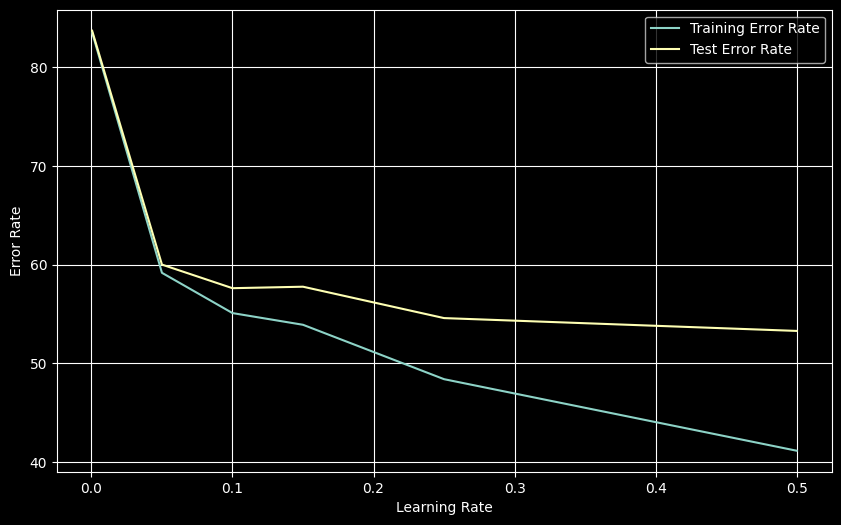

In [12]:
input_size = 3072
batch_size = 200
hidden_size = 250 # Best hidden size from previous step
num_hidden_layers = 1
num_classes = 10
epochs = 50 # Best number of epochs from previous step
learning_rates = [0.0005, 0.05, 0.1, 0.15, 0.25, 0.5]
randomize_weights = True # Best weights from previous step

train_error_rates = []
test_error_rates = []

# Load the datasets
train_loader, test_loader = load_CIFAR10(batch_size=batch_size)

# Train and test the model for each learning rate
for learning_rate in learning_rates:
    train_results, test_results = train_and_test(input_size, train_loader, test_loader, hidden_size, num_classes, num_hidden_layers, epochs, learning_rate, randomize_weights)
    
    # Append the final error rates to their respective lists
    train_error_rates.append(train_results[-1])
    test_error_rates.append(test_results[-1])

print(f'Best Training Error Rate: {min(train_error_rates)} from {learning_rates[train_error_rates.index(min(train_error_rates))]} learning rate')
print(f'Best Test Error Rate: {min(test_error_rates)} from {learning_rates[test_error_rates.index(min(test_error_rates))]} learning rate')

# Plot the error rates
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, train_error_rates, label='Training Error Rate')
plt.plot(learning_rates, test_error_rates, label='Test Error Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()

##### Explanation:

- Best Training Error Rate: 56.856% (0.5 learning rate)
- Best Test Error Rate: 58.67% (0.5 learning rate)

If we consult with the graph we can see that at a learning rate of 0.05 the error rate of the training and test data diverges from each other. As the learning rate increases, the error rate of the training data decreases quite a bit, but the error rate of the test data only decreases slightly. This is because the model is learning too much about the training data and is overfitting. This results in the model not being able to generalize well to the test data.

#### f) Various Hidden Layers (1-8)

Files already downloaded and verified
Files already downloaded and verified
Best Training Error Rate: 51.146 from 1 hidden layers
Best Test Error Rate: 58.99 from 1 hidden layers


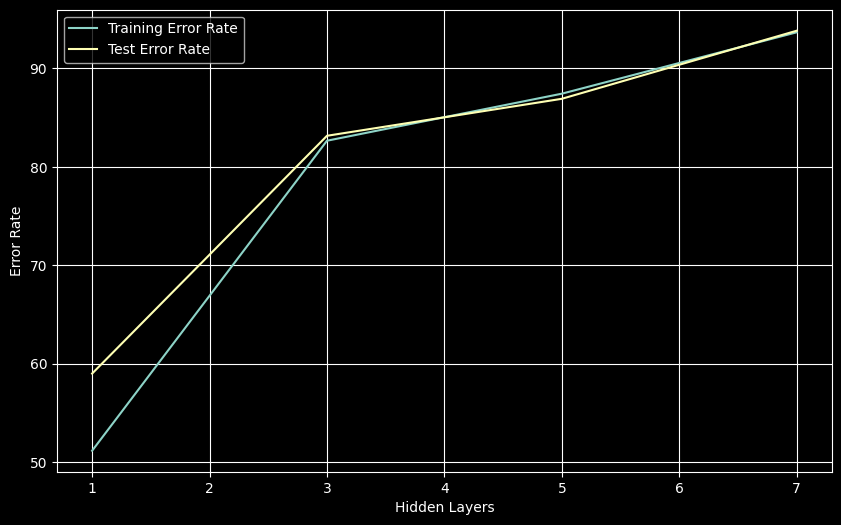

In [11]:
input_size = 3072
batch_size = 200
hidden_size = 250 # Best hidden size from previous step
num_classes = 10
epochs = 50 # Best number of epochs from previous step
learning_rate = 0.5 # Best learning rate from previous step
randomize_weights = True # Best weights from previous step
hidden_layers = [1, 3, 5, 7]

train_error_rates = []
test_error_rates = []

# Load the datasets
train_loader, test_loader = load_CIFAR10(batch_size=batch_size)

# Train and test the model for each number of hidden layers
for num_hidden_layers in hidden_layers:
    train_results, test_results = train_and_test(input_size, train_loader, test_loader, hidden_size, num_classes, num_hidden_layers, epochs, learning_rate, randomize_weights)
    
    # Append the final error rates to their respective lists
    train_error_rates.append(train_results[-1])
    test_error_rates.append(test_results[-1])

print(f'Best Training Error Rate: {min(train_error_rates)} from {hidden_layers[train_error_rates.index(min(train_error_rates))]} hidden layers')
print(f'Best Test Error Rate: {min(test_error_rates)} from {hidden_layers[test_error_rates.index(min(test_error_rates))]} hidden layers')

# Plot the error rates
plt.figure(figsize=(10, 6))
plt.plot(hidden_layers, train_error_rates, label='Training Error Rate')
plt.plot(hidden_layers, test_error_rates, label='Test Error Rate')
plt.xlabel('Hidden Layers')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()

##### Explanation:

- Best Training Error Rate: 51.146% (1 hidden layer, 300 nodes per layer)
- Best Testing Error Rate: 58.99% (1 hidden layer, 300 nodes per layer)

As the number of hidden layers increases, the error rate increases as well. There could be several reasons as to why this happens but I think that the most likely answer is that since we are using 300 neural nodes per layer, there is a high chance that with each added layer, the neural network is memorizing irrelevant features of the dataset or even the noise in the dataset (This is just the overfitting problem). We can see that at 7 layers the model becomes worse than true random which leads me to believe that the model is memorizing noise above all else. These results may be a product of the fact that we chose a high number of nodes per layer in the previous steps because we were only using one hidden layer. There is also a chance that the dataset is not large enough to train a neural network with this many layers and nodes per layer.

## Part 2: Deep Neural Network

I plan to use the ReLU activation function for the hidden layers, and softmax for the output layer.

Conceptually, a deep neural network is an FFN with a more than a "few" hidden layers. They are similar to MLPs but should have more layers.

### Part 2.1: Definitions and Part 1 Hyperparameters

#### Define Deep Neural Network Class

In [3]:
class DeepNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers, num_classes):
        super(DeepNN, self).__init__()

        # Flatten input layer
        self.flatten = nn.Flatten()
        layers = []
        in_size = input_size
        # Iterate through hidden layers and add them to the list of layers
        for _ in range(num_hidden_layers):
            layer = nn.Linear(in_size, hidden_size)
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')  # Initializing weights
            nn.init.zeros_(layer.bias)  # Initializing biases
            layers.append(layer)
            layers.append(nn.ReLU())
            in_size = hidden_size

        # Set hidden layers to a sequence of all layers we created
        self.hidden_layers = nn.Sequential(*layers)

        # Set output layer
        self.fc_out = nn.Linear(in_size, num_classes)

        # Initialize random weights
        nn.init.kaiming_uniform_(self.fc_out.weight, nonlinearity='relu') 
        # Initialize random biases
        nn.init.normal_(self.fc_out.bias)  

    def forward(self, x):

        # Flatten the input
        x = self.flatten(x)

        # Iterate through the layers and apply the ReLU activation function
        x = self.hidden_layers(x)

        # Get the output layer
        x = self.fc_out(x)

        # Apply softmax to the output layer
        return nn.functional.softmax(x, dim=1)

#### Define Test Function

Same as the test function for the feed forward neural network.

In [5]:
def test_model(test_loader, input_size, model):
    # Set the model to evaluation mode
    model.eval() 

    # Disable gradient calculation
    with torch.no_grad():
        total_correct = 0
        total_samples = 0

        # Iterate over the data in the test data loader
        for images, labels in test_loader:
            # Reshape the images and move them to the device (GPU if available)
            images = images.view(-1, input_size).requires_grad_().to(device)

            # Move the labels to the device (GPU if available)
            labels = labels.to(device)

            # Forward pass through the model
            outputs = model(images)
            
            # Get the predicted labels
            _, predicted = torch.max(outputs, 1)

            # Update the total number of samples
            total_samples += labels.size(0)

            # Move the data to the CPU if GPU is being used, and calculate the number of correct predictions
            if torch.cuda.is_available():
                total_correct += (predicted.cpu() == labels.cpu()).sum().item()
            else:
                total_correct += (predicted == labels).sum().item()

        # Calculate the accuracy and return error rate
        accuracy = 100 * total_correct / total_samples 
        error_rate = 100 - accuracy  
        return error_rate 

#### Define Train and Test Function

Very similar to the train_and_test function for the feed forward neural network. 

Use SGD instead of M-BGD (When we iterate over the training data we do not enumerate the dataloader).

In [7]:
# Function to train and test the model
def train_and_test(input_size, train_loader, test_loader, hidden_size, num_classes, num_hidden_layers, num_epochs, learning_rate):

    # Initialize the model
    model = DeepNN(input_size, hidden_size, num_hidden_layers, num_classes)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Lists to store error rates
    train_error_rates = []
    test_error_rates = []

    # Training loop
    for epoch in range(num_epochs):
        total_correct = 0
        total_samples = 0

        # Iterate over the data in the training data loader (SGD)
        for images, labels in train_loader:
            # Reshape the images and move them to the device (GPU if available)
            images = images.view(-1, input_size).requires_grad_().to(device)

            # Move the labels to the device (GPU if available)
            labels = labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Perform a forward pass through the model
            outputs = model(images)

            # Calculate the loss using cross-entropy loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()  # Update the model parameters

            # Get the predicted labels
            _, predicted = torch.max(outputs, 1)

            # Update the total number of samples
            total_samples += labels.size(0)

            # Move the data to the CPU if GPU is being used, and calculate the number of correct predictions
            if torch.cuda.is_available():
                total_correct += (predicted.cpu() == labels.cpu()).sum().item()
            else:
                total_correct += (predicted == labels).sum().item()

        # Calculate training error rate and append to list
        train_accuracy = 100 * total_correct / total_samples
        train_error_rate = 100 - train_accuracy
        train_error_rates.append(train_error_rate)

        # Test the model and append test error rate to list
        test_error_rate = test_model(test_loader, input_size, model)
        test_error_rates.append(test_error_rate)

    return train_error_rates, test_error_rates

#### No K-Fold Cross Validation

Normally a DNN would have more than 1 hidden layer but the assignment outline says to use the best parameters from part 1.

Files already downloaded and verified
Files already downloaded and verified
Epochs Tested: 10
Epochs Tested: 20
Epochs Tested: 30
Epochs Tested: 40
Epochs Tested: 50
Best Training Error Rate: 25.456000000000003 from 50 epochs
Best Test Error Rate: 47.69 from 40 epochs


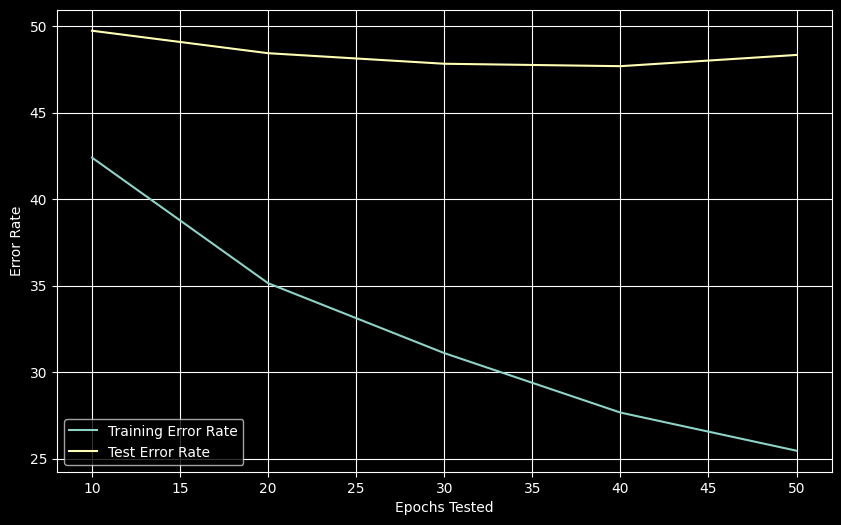

In [15]:
# Hyperparameters for the model and its training
input_size = 3072
batch_size = 200
hidden_size = 250 # Best hidden size from part 1
hidden_layers = 1 # Best number of hidden layers from part 1
num_classes = 10
learning_rate = 0.5 # Best learning rate from part 1
randomize_weights = True # Best weights from part 1
randomize_bias = True # See assignment instructions

# Test the model with multiple epochs
epochs = [10, 20, 30, 40, 50]

train_error_rates = []
test_error_rates = []

# Load the datasets
train_loader, test_loader = load_CIFAR10(batch_size=batch_size)

# Train and test the model for each number of epochs
for num_epochs in epochs:
    train_results, test_results = train_and_test(input_size, train_loader, test_loader, hidden_size, num_classes, hidden_layers, num_epochs, learning_rate, randomize_weights=randomize_weights, randomize_bias=randomize_bias)
    
    # Append the final error rates to their respective lists
    train_error_rates.append(train_results[-1])
    test_error_rates.append(test_results[-1])

    print(f'Epochs Tested: {num_epochs}')

print(f'Best Training Error Rate: {min(train_error_rates)} from {epochs[train_error_rates.index(min(train_error_rates))]} epochs')
print(f'Best Test Error Rate: {min(test_error_rates)} from {epochs[test_error_rates.index(min(test_error_rates))]} epochs')

# Plot the error rates
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_error_rates, label='Training Error Rate')
plt.plot(epochs, test_error_rates, label='Test Error Rate')
plt.xlabel('Epochs Tested')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)
plt.show()

#### Explanation:

- Best Training Error Rate: 25.456% (50 Epochs)
- Best Test Error Rate: 47.69% (40 Epochs)

The model architecture for part 1 and part 2 are very similar except for the fact that the activation function for part 2 is ReLU instead of sigmoid. Using ReLU over sigmoid in this case can solve some of the problems that sigmoid has such as vanishing gradients and slow convergence. This can explain why at 10 epochs our training error rate is already lower than part 1. This is also true for the testing error rate, but the difference is not as significant. It is also clear that with this model, if we want to get the best generalization, we should stop training at around 40 epochs. This is because the testing error rate starts to increase after 40 epochs. This is most likely due to overfitting. The change to SGD from M-BGD may have had an effect on the training and testing error rates, but I will see if this is true in part 3 since the model architecture should remain the same.

### 2.2: K-Fold Cross Validation Hyperparameter Tuning

#### Define Validation And Testing Function

Function used for validating or testing the model on a target dataset.

Returns F1 Score and Criterion loss (Cross-Entropy).

In [4]:
def validate_test(model, target_loader, criterion):

    # Set the model to evaluation mode
    model.eval()

    test_loss = 0.0
    predictions_test = []
    labels_test = []

    # Disable the gradient calculation
    with torch.no_grad():
        # Iterate through the target set (validation or test sets)
        for images, labels in target_loader:
            # Reshape the images and move them to the device (GPU if available)
            images = images.view(-1, input_size).requires_grad_().to(device)

            # Move the labels to the device (GPU if available)
            labels = labels.to(device)

            # Forward pass through the model
            outputs = model(images)

            # Calculate the loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Collect the predictions and labels
            predictions_test += outputs.argmax(dim=1).cpu().numpy().tolist()
            labels_test += labels.cpu().numpy().tolist()

    # Calculate the F1 score for the test set
    f1 = f1_score(labels_test, predictions_test, average='weighted')
    return f1, test_loss 

#### Define Train Function

In [5]:
# Train a DDN using SGD
def train(model, train_loader, criterion, optimizer):
    # Set model to training mode
    model.train()
    train_loss = 0.0
    predictions_train = []
    labels_train = []

    # Iterate through the training set (SGD)
    for images, labels in train_loader:
        #Reshape the images and move them to the device (GPU if available)
        images = images.view(-1, input_size).requires_grad_().to(device)

        # Move the labels to the device (GPU if available)
        labels = labels.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass through model
        outputs = model(images)

        # Get cross entropy loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate train loss
        train_loss += loss.item()

        # Get predictions and labels (we use .cpu() to move the data to the CPU if GPU is being used)
        predictions_train += outputs.argmax(dim=1).cpu().numpy().tolist()
        labels_train += labels.cpu().numpy().tolist()

    # Calculate F1 score
    f1 = f1_score(labels_train, predictions_train, average='weighted')

    # Return F1 and train loss
    return f1, train_loss


#### Define K-F Cross Validation Optimization Function

Function to train, validate, and test a MLP model using K-Fold Cross Validation.

This function is passed a parameter grid which contains all the hyperparameters to be tested.

If the parameter grid contains a single set of hyperparameters, then the function will train, validate, and test the model using those hyperparameters.

If the parameter grid contains multiple sets of hyperparameters, then the function will train, validate, and test the model using each set of hyperparameters and return the set of hyperparameters that resulted in the best validation F1 Score.

In [6]:
def kfold_train_optimize(input_size, batch_size, parameter_grid, epochs):

    # Initialize KFold with 5 folds
    kfold = KFold(n_splits=5, shuffle=True)

    # Used to determine if we should set pin_memory to true for the dataloaders if a GPU is present
    gpu_memory = False
    if torch.cuda.is_available():
        gpu_memory = True

    # This will be returned as a dictionary of the best parameters from the parameter grid.
    best_parameters = None

    # Set the best to infinity so it can be replaced by the first value smaller than it
    best_f1_score = float('inf')

    # Dictionaries to store the best cross entropy losses and F1 scores
    best_losses = {'train': float('inf'), 'val': float('inf'), 'test': float('inf')}
    best_f1_scores = {'train': 0, 'val': 0, 'test': 0}

    # Best value per epoch so we can graph these results for all datasets
    f1_scores_graph = {}
    loss_scores_graph = {}

    best_exec_time = float('inf')
    total_exec_time = 0

    total_exec_start = time.time()

    # Load the raw training data
    train_set, test_set = load_CIFAR10(batch_size=batch_size, raw=True)

    # Used to keep track of how many models we have trained (if we trying to find the best parameters)
    model_ind = 0

    # Stores all the data for each fold so we can graph it later, indexed by model index
    model_fold_f1_data = []
    model_loss_data = []

    # Iterate over the parameter grid to find the best parameters for the model
    # We are trying to find the greatest F1 score for the validation set since we are working on a classification model
    for params in ParameterGrid(parameter_grid):

        # Create a copy of the parameter grid and remove the learning rate so we don't pass it to the model
        temp_params = params.copy()
        temp_params.pop('learning_rate')

        # Time training for each model so we can return it along with the best parameters
        start_time = time.time()

        # Initialize the model (we pass it a dictionary of parameters using **params to unpack the dictionary with named variables)
        model = DeepNN(input_size, **temp_params)
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=params['learning_rate'])
        
        # Dictionaries to store the final F1 scores and cross entropy losses after training
        fold_f1_scores = {'train': [], 'val': [], 'test': []}
        fold_losses = {'train': [], 'val': [], 'test': []}

        # Iterate through folds for k-fold cross validation (combine all batches)
        for fold, (train_idx, val_idx) in enumerate(kfold.split(train_set)):
            
            # Get subsets for training and validation from the k-fold split
            train_subset = torch.utils.data.Subset(train_set, train_idx)
            val_subset = torch.utils.data.Subset(train_set, val_idx)

            # Declare dataloaders for all 3 datasets
            train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, pin_memory=gpu_memory)
            val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False, pin_memory=gpu_memory)
            test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=gpu_memory)

            # Initialize variables
            train_f1 = 0
            train_loss = 0

            # Store the validation F1 scores for each epoch so we can find the best epoch
            val_f1_scores = []

            # train the model
            for epoch in range(epochs):

                # Train the model on the training set
                train_f1, train_loss = train(model, train_loader, criterion, optimizer)

                # Validate the model on the validation set
                val_f1, val_loss = validate_test(model, val_loader, criterion)
                
                # Append each validation F1 score to the lists
                val_f1_scores.append(val_f1)

                # Test the model on the testing set
                test_f1, test_loss = validate_test(model, test_loader, criterion)

            # Calculate the execution time
            exec_time = time.time() - start_time

            # Get best epoch for the validation set
            best_epoch = val_f1_scores.index(max(val_f1_scores))

            # Add the final F1 scores and cross entropy losses to their respective lists for fold data
            fold_f1_scores['train'].append(train_f1)
            fold_f1_scores['val'].append(val_f1)
            fold_f1_scores['test'].append(test_f1)
            fold_losses['train'].append(train_loss)
            fold_losses['val'].append(val_loss)
            fold_losses['test'].append(test_loss)

            # Update the best parameters and scores if the current model outperforms the previous best
            # Validation F1 is our metric since we are working on a classification model
            if val_f1 > best_f1_scores['val']:
                best_losses = {'train': train_loss, 'val': val_loss, 'test': test_loss}
                best_f1_scores = {'train': train_f1, 'val': val_f1, 'test': test_f1}

                # Record the parameters used for this model
                best_params = params.copy()
                    
                # Record the best epoch to our best params as well
                best_params['epochs'] = best_epoch
                best_params['fold'] = fold
                best_params['model'] = model_ind
                best_exec_time = exec_time

            # Go to the next fold if there is one

        # Add the fold data to the list of model data
        model_fold_f1_data.append(fold_f1_scores)
        model_loss_data.append(fold_losses)

        # If we are trying to find the best parameters, we need to know which model the best parameters came from
        model_ind += 1

        # Test the next set of parameters on a new model (if there is one)

    # Calculate the total execution time for finding the optimal parameters
    total_exec_time = time.time() - total_exec_start

    # Return the best parameters, scores, and times
    return best_losses, best_f1_scores, best_params, model_fold_f1_data, model_loss_data, best_exec_time, total_exec_time

#### Train Model Using K-Fold Cross Validation

The hyperparameters used are the optimal hyperparameters found in part 1. Even though this is a deep neural network, we will only be using 1 layer since that is what we originally determined to be best.

If the code for the bonus section finishes running, then the optimal hyperparameters will be listed there.

In [11]:
input_size = 3072
batch_size = 200

# Best parameters from part 1
parameter_grid = {
        'hidden_size': [250],
        'num_hidden_layers': [1],
        'num_classes': [10],
        'learning_rate': [0.5],
}

epochs = 50

# Train and test a model using K-Fold Cross Validation. Returns the best parameters, scores, and times.
best_losses, best_f1_scores, best_params, model_fold_f1_data, model_loss_data, best_exec_time, total_exec_time = kfold_train_optimize(input_size, batch_size, parameter_grid, epochs)

Files already downloaded and verified
Files already downloaded and verified


a1) Cross Entropy Loss

Training Loss: 327.58110451698303
Validation Loss: 82.02321231365204
Testing Loss: 96.60959112644196

a2) F1 Score/F-Measure

Training F1 Score: 0.8208309893109559
Validation F1 Score: 0.8213876053264106
Testing F1 Score: 0.5244811065890083

b) Hyperparameters and Execution Times

Hidden Layers: 1
Hidden Nodes: 250
Learning Rate: 0.5
Best Fold: 4
Execution Time: 2302.854738473892 seconds


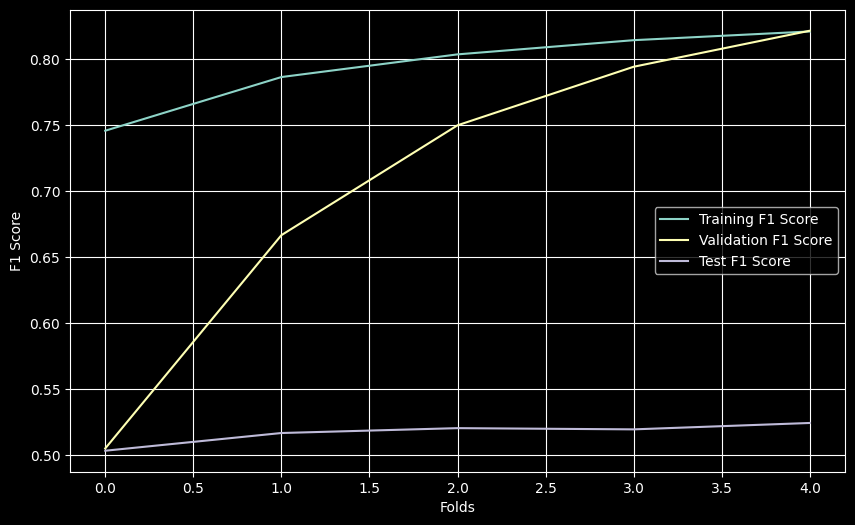

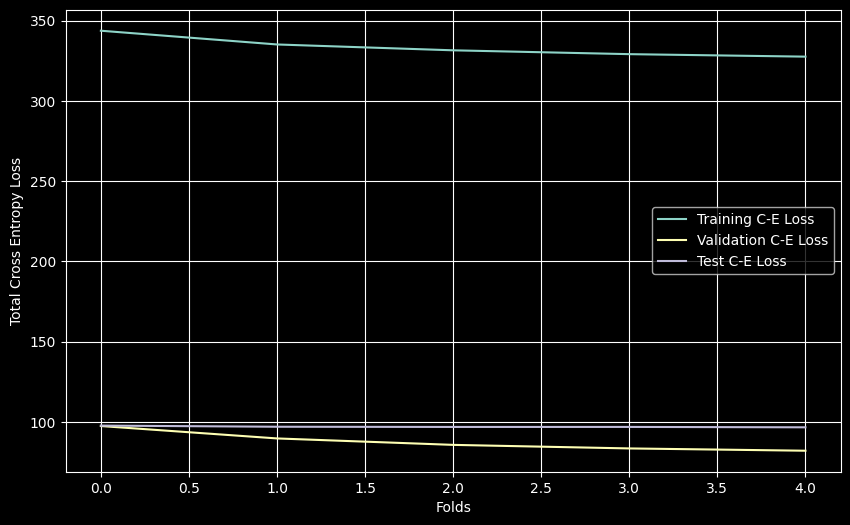

In [12]:
best_model = best_params['model']

# Get the fold data for the best model
best_f1_data = model_fold_f1_data[best_model]
best_loss_data = model_loss_data[best_model]

print('a1) Cross Entropy Loss\n')

print(f'Training Loss: {best_losses["train"]}')
print(f'Validation Loss: {best_losses["val"]}')
print(f'Testing Loss: {best_losses["test"]}\n')

print('a2) F1 Score/F-Measure\n')

print(f'Training F1 Score: {best_f1_scores["train"]}')
print(f'Validation F1 Score: {best_f1_scores["val"]}')
print(f'Testing F1 Score: {best_f1_scores["test"]}\n')

print('b) Hyperparameters and Execution Times\n')

print(f'Hidden Layers: {best_params["num_hidden_layers"]}')
print(f'Hidden Nodes: {best_params["hidden_size"]}')
print(f'Learning Rate: {best_params["learning_rate"]}')
print(f'Best Fold: {best_params["fold"]}')
print(f'Execution Time: {best_exec_time} seconds')

# Plot the F1 Scores
plt.figure(figsize=(10, 6))
plt.plot(best_f1_data['train'], label='Training F1 Score')
plt.plot(best_f1_data['val'], label='Validation F1 Score')
plt.plot(best_f1_data['test'], label='Test F1 Score')
plt.xlabel('Folds')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot the C-E losses
plt.figure(figsize=(10, 6))
plt.plot(best_loss_data['train'], label='Training C-E Loss')
plt.plot(best_loss_data['val'], label='Validation C-E Loss')
plt.plot(best_loss_data['test'], label='Test C-E Loss')
plt.xlabel('Folds')
plt.ylabel('Total Cross Entropy Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Explanation:

**F1 Scores**
- Training F1 Score: 0.8208309893109559
- Validation F1 Score: 0.8213876053264106
- Testing F1 Score: 0.5244811065890083

When training the model using 5-fold cross validation we measure the final F1-score (F-Measure) and final cross-entropy loss for each fold. We use F1-score over error rate in this case because the F1-score is a better evaluation for classification models. We can see as we reach the 5th fold, the F1-scores for the training, and validation sets converge with an approximate value of 82. However, the F1-score for the testing set is much lower at approximately 52. As stated in previous parts of the assignment, this is probably due to the fact that the model is overfitting to the training and validation datasets, and cannot properly generalize onto the test dataset.

**Total Cross-Entropy Loss**
- Training Loss: 327.58110451698303
- Validation Loss: 82.02321231365204
- Testing Loss: 96.60959112644196

The total cross-entropy loss for the training data steadily decreases per fold, reaching a total loss of 327.58. This means that with every fold, the model is improving it's ability to make accurate predictions on the training dataset. As for the validation dataset, the total cross-entropy loss 82.02 at fold 5, which suggests that the model is performing okay on the validation dataset. Finally, the total cross-entropy loss for the testing dataset is 96.61, which is higher than the validation loss, which suggests that the model's performance is consistent but it does not handle the unknown data from the new dataset since it is overfitting to the training and validation datasets.

**It is important to note that the parameters used to train the model might not be the best parameters since these parameters were found back in part 1 using a different model that was similar in architecure.**

#### Bonus: Find Optimal Parameters Using K-Fold Cross-Validation and Grid Search

My K-fold cross-validation function was already programmed in such a way that handled parameter grids before the assignment revision so I never had to change it, but it takes forever to run. I tried reducing the number of parameters in the grid, but as i was running the test overnight on Thursday, the power cut out and I lost all progress.

I would not recommend running this code since it takes a while to run, just take a look at it k_fold_train_optimize() to see how I implemented the grid search.

Uncomment everything in the cell below to run the code.

In [ ]:
# input_size = 3072
# batch_size = 200

# # Parameter grid to find optimal parameters for the model.
# parameter_grid = {
#         'hidden_size': [25, 75, 150, 250],
#         'num_hidden_layers': [1, 3, 5, 7],
#         'num_classes': [10],
#         'learning_rate': [0.05, 0.1, 0.5],
# }

# # I reduced the number of epochs to 5 for performance reasons
# epochs = 5

# # Train and test a model using K-Fold Cross Validation. Returns the best parameters, scores, and times.
# best_losses, best_f1_scores, best_params, model_fold_f1_data, model_loss_data, best_exec_time, total_exec_time = kfold_train_optimize(input_size, batch_size, parameter_grid, epochs)

# best_model = best_params['model']

# # Get the fold data for the best model
# best_f1_data = model_fold_f1_data[best_model]
# best_loss_data = model_loss_data[best_model]

# print('a1) Cross Entropy Loss\n')

# print(f'Training Loss: {best_losses["train"]}')
# print(f'Validation Loss: {best_losses["val"]}')
# print(f'Testing Loss: {best_losses["test"]}\n')

# print('a2) F1 Score/F-Measure\n')

# print(f'Training F1 Score: {best_f1_scores["train"]}')
# print(f'Validation F1 Score: {best_f1_scores["val"]}')
# print(f'Testing F1 Score: {best_f1_scores["test"]}\n')

# print('b) Hyperparameters and Execution Times\n')

# print(f'Hidden Layers: {best_params["num_hidden_layers"]}')
# print(f'Hidden Nodes: {best_params["hidden_size"]}')
# print(f'Learning Rate: {best_params["learning_rate"]}')
# print(f'Best Fold: {best_params["fold"]}')
# print(f'Best Execution Time: {best_exec_time} seconds')
# print(f'Total Execution Time: {total_exec_time} seconds')

# # Plot the F1 Scores
# plt.figure(figsize=(10, 6))
# plt.plot(best_f1_data['train'], label='Training F1 Score')
# plt.plot(best_f1_data['val'], label='Validation F1 Score')
# plt.plot(best_f1_data['test'], label='Test F1 Score')
# plt.xlabel('Folds')
# plt.ylabel('F1 Score')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot the C-E losses
# plt.figure(figsize=(10, 6))
# plt.plot(best_loss_data['train'], label='Training C-E Loss')
# plt.plot(best_loss_data['val'], label='Validation C-E Loss')
# plt.plot(best_loss_data['test'], label='Test C-E Loss')
# plt.xlabel('Folds')
# plt.ylabel('Total Cross Entropy Loss')
# plt.legend()
# plt.grid(True)
# plt.show()

## Part 3: Multi-Layer Neural Network

I plan to use the ReLU activation function for the hidden layers, and softmax for the output layer.

### Define Multi-Layer Neural Network (MLP)

This NN is identical to the DNN from part 2.

They are both FFNs that use ReLU as an activation function and softmax on the output layer.

When I train and test the model I will use **mini-batch gradient** descent instead of **stochastic gradient descent**.

In [13]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_hidden_layers, num_classes):
        super(MLP, self).__init__()

        # Flatten input layer
        self.flatten = nn.Flatten()
        layers = []
        in_size = input_size
        # Iterate through hidden layers and add them to the list of layers
        for _ in range(num_hidden_layers):
            layer = nn.Linear(in_size, hidden_size)
            nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')  # Initializing weights
            nn.init.zeros_(layer.bias)  # Initializing biases
            layers.append(layer)
            layers.append(nn.ReLU())
            in_size = hidden_size

        # Set hidden layers to a sequence of all layers we created
        self.hidden_layers = nn.Sequential(*layers)

        # Set output layer
        self.fc_out = nn.Linear(in_size, num_classes)

        # Initialize random weights
        nn.init.kaiming_uniform_(self.fc_out.weight, nonlinearity='relu') 
        # Initialize random biases
        nn.init.normal_(self.fc_out.bias)  

    def forward(self, x):

        # Flatten the input
        x = self.flatten(x)

        # Iterate through the layers and apply the ReLU activation function
        x = self.hidden_layers(x)

        # Get the output layer
        x = self.fc_out(x)

        # Apply softmax to the output layer
        return nn.functional.softmax(x, dim=1)  

### Define Validation And Testing Function

Function used for validating or testing the model on a target dataset.

Returns F1 Score and Criterion loss (Cross-Entropy).

In [14]:
def validate_test(model, target_loader, criterion):

    # Set the model to evaluation mode
    model.eval()

    test_loss = 0.0
    predictions_test = []
    labels_test = []

    # Disable the gradient calculation
    with torch.no_grad():
        # Iterate through the target set (validation or test sets)
        for images, labels in target_loader:
            # Reshape the images and move them to the device (GPU or CPU)
            images = images.view(-1, input_size).requires_grad_().to(device)
            labels = labels.to(device)

            # Forward pass through the model
            outputs = model(images)

            # Calculate the loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Collect the predictions and labels
            predictions_test += outputs.argmax(dim=1).cpu().numpy().tolist()
            labels_test += labels.cpu().numpy().tolist()

    # Calculate the F1 score for the test set
    f1 = f1_score(labels_test, predictions_test, average='weighted')
    return f1, test_loss 

### Define M-BGD Train 

Function used for training a MLP model using mini-batch gradient descent.

Returns F1 Score and Criterion loss (Cross-Entropy).

In [15]:
def train(model, train_loader, criterion, optimizer):
    # Set model to training mode
    model.train()
    train_loss = 0.0
    predictions_train = []
    labels_train = []

    # Iterate through the training set (M-BGD)
    for i, (images, labels) in enumerate(train_loader):
        #Reshape the images and move them to the device (GPU or CPU)
        images = images.view(-1, input_size).requires_grad_().to(device)
        labels = labels.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass through model
        outputs = model(images)

        # Get cross entropy loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate train loss
        train_loss += loss.item()

        # Get predictions and labels (we use .cpu() to move the data to the CPU if GPU is being used)
        predictions_train += outputs.argmax(dim=1).cpu().numpy().tolist()
        labels_train += labels.cpu().numpy().tolist()

    # Calculate F1 score
    f1 = f1_score(labels_train, predictions_train, average='weighted')

    # Return F1 and train loss
    return f1, train_loss


### Define K-F Cross Validation Optimization Function

Function to train, validate, and test a MLP model using K-Fold Cross Validation.

This function is passed a parameter grid which contains all the hyperparameters to be tested.

If the parameter grid contains a single set of hyperparameters, then the function will train, validate, and test the model using those hyperparameters.

If the parameter grid contains multiple sets of hyperparameters, then the function will train, validate, and test the model using each set of hyperparameters and return the set of hyperparameters that resulted in the best validation F1 Score.

In [16]:
# Function to train, validate and test a MLP model using K-Fold Cross Validation (Can be used to find the best parameters)
def kfold_train_optimize(input_size, batch_size, parameter_grid, epochs):

    # Initialize KFold with 5 folds
    kfold = KFold(n_splits=5, shuffle=True)

    # Used to determine if we should set pin_memory to true for the dataloaders if a GPU is present
    gpu_memory = False
    if torch.cuda.is_available():
        gpu_memory = True

    # This will be returned as a dictionary of the best parameters from the parameter grid.
    best_parameters = None

    # Set the best to infinity so it can be replaced by the first value smaller than it
    best_f1_score = float('inf')

    # Dictionaries to store the best cross entropy losses and F1 scores
    best_losses = {'train': float('inf'), 'val': float('inf'), 'test': float('inf')}
    best_f1_scores = {'train': 0, 'val': 0, 'test': 0}

    # Best value per epoch so we can graph these results for all datasets
    f1_scores_graph = {}
    loss_scores_graph = {}

    best_exec_time = float('inf')
    total_exec_time = 0

    total_exec_start = time.time()

    # Load the raw training data
    train_set, test_set = load_CIFAR10(batch_size=batch_size, raw=True)

    # Used to keep track of how many models we have trained (if we trying to find the best parameters)
    model_ind = 0

    # Stores all the data for each fold so we can graph it later, indexed by model index
    model_fold_f1_data = []
    model_loss_data = []

    # Iterate over the parameter grid to find the best parameters for the model
    # We are trying to find the greatest F1 score for the validation set since we are working on a classification model
    for params in ParameterGrid(parameter_grid):

        # Create a copy of the parameter grid and remove the learning rate so we don't pass it to the model
        temp_params = params.copy()
        temp_params.pop('learning_rate')

        # Time training for each model so we can return it along with the best parameters
        start_time = time.time()

        # Initialize the model (we pass it a dictionary of parameters using **params to unpack the dictionary with named variables)
        model = MLP(input_size, **temp_params)
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=params['learning_rate'])
        
        # Dictionaries to store the final F1 scores and cross entropy losses after training
        fold_f1_scores = {'train': [], 'val': [], 'test': []}
        fold_losses = {'train': [], 'val': [], 'test': []}

        # Iterate through folds for k-fold cross validation (combine all batches)
        for fold, (train_idx, val_idx) in enumerate(kfold.split(train_set)):
            
            # Get subsets for training and validation from the k-fold split
            train_subset = torch.utils.data.Subset(train_set, train_idx)
            val_subset = torch.utils.data.Subset(train_set, val_idx)

            # Declare dataloaders for all 3 datasets
            train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, pin_memory=gpu_memory)
            val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False, pin_memory=gpu_memory)
            test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=gpu_memory)

            # Initialize variables
            train_f1 = 0
            train_loss = 0

            # Store the validation F1 scores for each epoch so we can find the best epoch
            val_f1_scores = []

            # train the model
            for epoch in range(epochs):

                # Train the model on the training set
                train_f1, train_loss = train(model, train_loader, criterion, optimizer)

                # Validate the model on the validation set
                val_f1, val_loss = validate_test(model, val_loader, criterion)
                
                # Append each validation F1 score to the lists
                val_f1_scores.append(val_f1)

                # Test the model on the testing set
                test_f1, test_loss = validate_test(model, test_loader, criterion)

            # Calculate the execution time
            exec_time = time.time() - start_time

            # Get best epoch for the validation set
            best_epoch = val_f1_scores.index(max(val_f1_scores))

            # Add the final F1 scores and cross entropy losses to their respective lists for fold data
            fold_f1_scores['train'].append(train_f1)
            fold_f1_scores['val'].append(val_f1)
            fold_f1_scores['test'].append(test_f1)
            fold_losses['train'].append(train_loss)
            fold_losses['val'].append(val_loss)
            fold_losses['test'].append(test_loss)

            # Update the best parameters and scores if the current model outperforms the previous best
            # Validation F1 is our metric since we are working on a classification model
            if val_f1 > best_f1_scores['val']:
                best_losses = {'train': train_loss, 'val': val_loss, 'test': test_loss}
                best_f1_scores = {'train': train_f1, 'val': val_f1, 'test': test_f1}

                # Record the parameters used for this model
                best_params = params.copy()
                    
                # Record the best epoch to our best params as well
                best_params['epochs'] = best_epoch
                best_params['fold'] = fold
                best_params['model'] = model_ind
                best_exec_time = exec_time

            # Go to the next fold if there is one

        # Add the fold data to the list of model data
        model_fold_f1_data.append(fold_f1_scores)
        model_loss_data.append(fold_losses)

        # If we are trying to find the best parameters, we need to know which model the best parameters came from
        model_ind += 1

        # Test the next set of parameters on a new model (if there is one)

    # Calculate the total execution time for finding the optimal parameters
    total_exec_time = time.time() - total_exec_start

    # Return the best parameters, scores, and times
    return best_losses, best_f1_scores, best_params, model_fold_f1_data, model_loss_data, best_exec_time, total_exec_time

#### Train Model Using K-Fold Cross Validation

Normally an MLP would have a few hidden layers, but I am using the hyperparameters found in part 1.

In [17]:
input_size = 3072
batch_size = 200

# Best parameters from part 1
parameter_grid = {
        'hidden_size': [250],
        'num_hidden_layers': [1],
        'num_classes': [10],
        'learning_rate': [0.5],
}

epochs = 50

# Train and test a model using K-Fold Cross Validation. Returns the best parameters, scores, and times.
best_losses, best_f1_scores, best_params, model_fold_f1_data, model_loss_data, best_exec_time, total_exec_time = kfold_train_optimize(input_size, batch_size, parameter_grid, epochs)

Files already downloaded and verified
Files already downloaded and verified


a1) Cross Entropy Loss

Training Loss: 327.94288408756256
Validation Loss: 81.83214545249939
Testing Loss: 96.63838982582092

a2) F1 Score/F-Measure

Training F1 Score: 0.8198875082239109
Validation F1 Score: 0.8260454919427781
Testing F1 Score: 0.5244327355633768

b) Hyperparameters and Execution Times

Hidden Layers: 1
Hidden Nodes: 250
Learning Rate: 0.5
Best Fold: 4
Best Execution Time: 2447.7065765857697


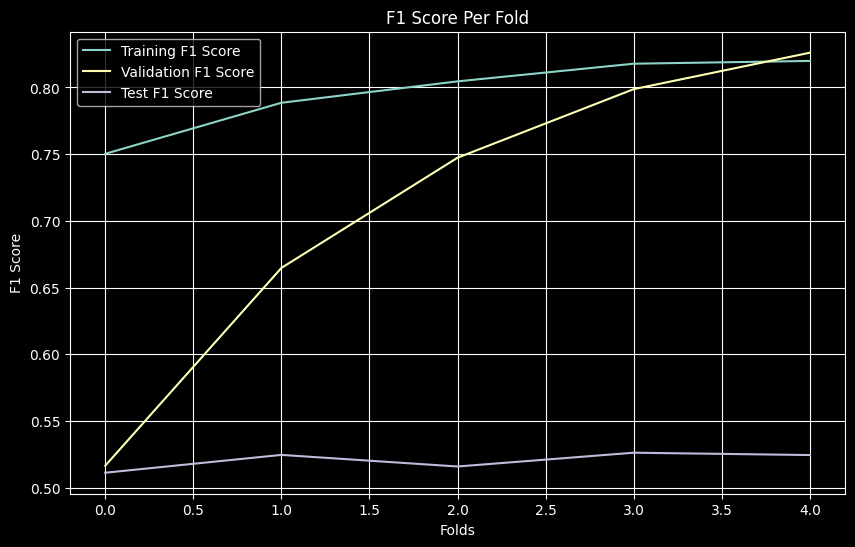

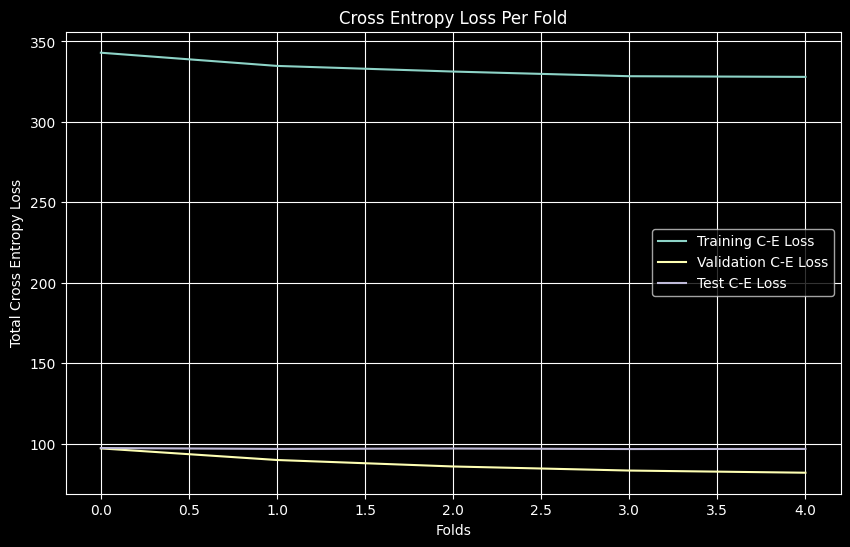

In [20]:
best_model = best_params['model']

# Get the fold data for the best model
best_f1_data = model_fold_f1_data[best_model]
best_loss_data = model_loss_data[best_model]

print('a1) Cross Entropy Loss\n')

print(f'Training Loss: {best_losses["train"]}')
print(f'Validation Loss: {best_losses["val"]}')
print(f'Testing Loss: {best_losses["test"]}\n')

print('a2) F1 Score/F-Measure\n')

print(f'Training F1 Score: {best_f1_scores["train"]}')
print(f'Validation F1 Score: {best_f1_scores["val"]}')
print(f'Testing F1 Score: {best_f1_scores["test"]}\n')

print('b) Hyperparameters and Execution Times\n')

print(f'Hidden Layers: {best_params["num_hidden_layers"]}')
print(f'Hidden Nodes: {best_params["hidden_size"]}')
print(f'Learning Rate: {best_params["learning_rate"]}')
print(f'Best Fold: {best_params["fold"]}')
print(f'Best Execution Time: {best_exec_time}')

# Plot the F1 Scores
plt.figure(figsize=(10, 6))
plt.plot(best_f1_data['train'], label='Training F1 Score')
plt.plot(best_f1_data['val'], label='Validation F1 Score')
plt.plot(best_f1_data['test'], label='Test F1 Score')
plt.title('F1 Score Per Fold')
plt.xlabel('Folds')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot the C-E losses
plt.figure(figsize=(10, 6))
plt.plot(best_loss_data['train'], label='Training C-E Loss')
plt.plot(best_loss_data['val'], label='Validation C-E Loss')
plt.plot(best_loss_data['test'], label='Test C-E Loss')
plt.title('Cross Entropy Loss Per Fold')
plt.xlabel('Folds')
plt.ylabel('Total Cross Entropy Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Explanation:

**F1 Scores**
- Training F1 Score: 0.8198875082239109
- Validation F1 Score: 0.8260454919427781
- Testing F1 Score: 0.5244327355633768

When training the model using 5-fold cross validation we measure the final F1-score (F-Measure) and final cross-entropy loss for each fold. We use F1-score over error rate in this case because the F1-score is a better evaluation for classification models. We can see as we reach the 5th fold, the F1-scores for the training, and validation sets converge with an approximate value of 82. However, the F1-score for the testing set is much lower at approximately 52. As stated in previous parts of the assignment, this is probably due to the fact that the model is overfitting to the training and validation datasets, and cannot properly generalize onto the test dataset.

**Total Cross-Entropy Loss**
- Training Loss: 327.94288408756256
- Validation Loss: 81.83214545249939
- Testing Loss: 96.63838982582092

The total cross-entropy loss for the training data steadily decreases per fold, reaching a total loss of 327.58. This means that with every fold, the model is improving it's ability to make accurate predictions on the training dataset. As for the validation dataset, the total cross-entropy loss 82.02 at fold 5, which suggests that the model is performing okay on the validation dataset. Finally, the total cross-entropy loss for the testing dataset is 96.61, which is higher than the validation loss, which suggests that the model's performance is consistent but it does not handle the unknown data from the new dataset since it is overfitting to the training and validation datasets.

**These results are near identical to the results in part 2 which is expected since the model architecture is the same, the only difference is that we are using mini-batch gradient descent instead of stochastic gradient descent. We will compare the models in the next part.**

**It is important to note that the parameters used to train the model might not be the best parameters since these parameters were found back in part 1 using a different model that was similar in architecure.**

#### Bonus: Find Optimal Parameters Using K-Fold Cross-Validation and Grid Search

Works the same as part 2. Don't have any results to show since it takes a long time to run and my power went out thursday night.

I would not recommend running this code since it takes a while to run, just take a look at it k_fold_train_optimize() to see how I implemented the grid search.

Uncomment everything in the cell below to run the code.

In [ ]:
# input_size = 3072
# batch_size = 200

# # Parameter grid to find optimal parameters for the model.
# parameter_grid = {
#         'hidden_size': [25, 75, 150, 250],
#         'num_hidden_layers': [1, 3, 5, 7],
#         'num_classes': [10],
#         'learning_rate': [0.05, 0.1, 0.5],
# }

# # I reduced the number of epochs to 5 for performance reasons
# epochs = 5

## Train and test a model using K-Fold Cross Validation. Returns the best parameters, scores, and times.
# best_losses, best_f1_scores, best_params, model_fold_f1_data, model_loss_data, best_exec_time, total_exec_time = kfold_train_optimize(input_size, batch_size, parameter_grid, epochs)

# best_model = best_params['model']

# # Get the fold data for the best model
# best_f1_data = model_fold_f1_data[best_model]
# best_loss_data = model_loss_data[best_model]

# print('a1) Cross Entropy Loss\n')

# print(f'Training Loss: {best_losses["train"]}')
# print(f'Validation Loss: {best_losses["val"]}')
# print(f'Testing Loss: {best_losses["test"]}\n')

# print('a2) F1 Score/F-Measure\n')

# print(f'Training F1 Score: {best_f1_scores["train"]}')
# print(f'Validation F1 Score: {best_f1_scores["val"]}')
# print(f'Testing F1 Score: {best_f1_scores["test"]}\n')

# print('b) Hyperparameters and Execution Times\n')

# print(f'Hidden Layers: {best_params["num_hidden_layers"]}')
# print(f'Hidden Nodes: {best_params["hidden_size"]}')
# print(f'Learning Rate: {best_params["learning_rate"]}')
# print(f'Best Fold: {best_params["fold"]}')
# print(f'Best Execution Time: {best_exec_time} seconds')
# print(f'Total Execution Time: {total_exec_time} seconds')

# # Plot the F1 Scores
# plt.figure(figsize=(10, 6))
# plt.plot(best_f1_data['train'], label='Training F1 Score')
# plt.plot(best_f1_data['val'], label='Validation F1 Score')
# plt.plot(best_f1_data['test'], label='Test F1 Score')
# plt.xlabel('Folds')
# plt.ylabel('F1 Score')
# plt.legend()
# plt.grid(True)
# plt.show()

# # Plot the C-E losses
# plt.figure(figsize=(10, 6))
# plt.plot(best_loss_data['train'], label='Training C-E Loss')
# plt.plot(best_loss_data['val'], label='Validation C-E Loss')
# plt.plot(best_loss_data['test'], label='Test C-E Loss')
# plt.xlabel('Folds')
# plt.ylabel('Total Cross Entropy Loss')
# plt.legend()
# plt.grid(True)
# plt.show()

## Part 4: Comparisons

I chose to use the ReLU activation functions for both models since they were of similar architecture and I was curious to see what kind of a difference SGD would make over M-BGD. ReLU is also a good choice since we are working with a complex dataset and do not want to worry about vanishing gradients.

Comparing the models from parts 2.2 and 3.1 is kind of difficult since the models are very similar and we are using the hyperparameters from part 1 which may not be optimal for either of these models. The first issue is that these are supposed to be Deep and Multi-Layered models, but we are only using 1 hidden layer to test them since that is what we found worked best in part 1. Ultimately, the only difference between the two models is that the Deep Neural Network is being trained using Stochastic Gradient Descent, and the Multi-Layered Neural Network is being trained using Mini-Batch Gradient Descent. The results for both models are very similar, but the Deep Neural Network performed a tiny bit better than the Multi-Layered Neural Network. This is most likely due to the fact that M-BGD is more sensitive to the learning rate than SGD is, and the learning rate may not be optimal for the model. This is also most likely why the Multi-Layered Neural Network took ~145 seconds longer to train compared to the Deep Neural Network.

As for the F1-Scores, the training and validation F1-Scores are very similar for both models, but F1-Scores are slightly higher for the Deep Neural Network for all datasets.

Finally, the total cross-entropy loss for the training and validation datasets are very similar for both models, but the total cross-entropy loss for the testing dataset is slightly higher for the Multi-Layered Neural Network, which is most likely a product of the difference between SGD and M-BGD, since M-BGD can also introduce more noise into the model than SGD can.

If it didn't take so long to train the models, I would have liked to find the optimal parameters using grid search and k-fold cross validation for both models, but I was unable to do so due to time constraints.

**Conclusion: Deep Neural Network with SGD performs slightly better than Multi-Layered Neural Network with M-BGD, but the difference is not significant. A Convolutional Neural Network would most likely outperform both of them and be far more practical, especially since we are working with images.**